<a href="https://colab.research.google.com/github/tjubes/DataMining/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import collections
import pandas as pd
import random
from collections import Counter
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt

class DecisionNode():
    def __init__(self, feature=None, splitpoint=None, left=None, right=None, value=None, leaf=False):
      self.feature = feature          # Feature to split on, column index
      self.splitpoint = splitpoint    # Threshold value for the split
      self.left = left                # Left subtree
      self.right = right              # Right subtree
      self.value = value              # If leaf node, the predicted class
      self.leaf = leaf                # If node is leaf node

    def is_leaf_node(self):
      return self.leaf

def impurity(a):
  i = (np.count_nonzero(a == 0)/len(a))*(1-np.count_nonzero(a == 0)/len(a))
  return i

def bestsplit(x,y, minleaf):
# this function is for a single feature
#return best splitpoint, reduction of splitpoint (gini index)

  #The best split is the split that achieves the highest impurity reduction.
  impurity_parent = impurity(y)

  x_sorted = np.sort(np.unique(x))
  x_splitpoints = (x_sorted[0:(len(x_sorted)-1)]+x_sorted[1:(len(x_sorted))])/2

  reductions = []
  for s in x_splitpoints:
    #go over all the splitpoints
    left = impurity(y[x <= s])
    l = len(y[x <= s])/len(y)
    right = impurity(y[x > s])
    r = len(y[x > s])/len(y)

    #calculate gini reduction
    reduction = impurity_parent - ((l*left) + r*(right))

    #only if minleaf parameter is correct
    if (len(y[x<=s]) >= minleaf) and (len(y[x>s]) >= minleaf):
      reductions.append(reduction)

  # the reductions list is empty if the minleaf constraint is not satisfied
  if reductions == []:
    return None, 0

  best_splitpoint = x_splitpoints[reductions.index(max(reductions))]

  return best_splitpoint, max(reductions)

def split(x,y,minleaf,nfeat):
  #this function finds which feature has the best split, using the best_split function
  # which feature do we split on, and what is the threshold?
  best_reduction = 0
  best_splitpoint = None
  column_i = None
  i = 0
  n_features = len(x.T)

  #which random features we split on
  random_features = random.sample(range(0, n_features), nfeat)

  for index in random_features:
    splitpoint, reduction = bestsplit(x[:, index],y,minleaf)

    if reduction > best_reduction:
      best_reduction = reduction
      best_splitpoint = splitpoint
      column_i = index
    i+=1
  return best_splitpoint, column_i

def tree_grow(x, y, nmin, minleaf, nfeat):
  observations = len(x)

  #the number of observations that a node must contain at least, for it to be
  #allowed to be split
  #also if the node is already pure, splitting is not needed anymore
  if observations < nmin or np.all(y == y[0]): #is np.all(y == 0) correct?
    return DecisionNode(value=y, leaf=True)

  #find the column that has the best quality of split
  splitpoint, feature_index = split(x,y,minleaf,nfeat)

  #if the minleaf  constraint is not sasisfied, so if no split can be found that
  #creates a node with fewer than minleaf observations is not acceptable.
  #leaf node created
  if feature_index == None:
    return DecisionNode(value=y, leaf=True)

  #left
  y_l = y[x[:,feature_index]<=splitpoint]
  x_l = x[np.where(x[:,feature_index]<=splitpoint)]

  #right
  y_r = y[x[:,feature_index]>splitpoint]
  x_r = x[np.where(x[:,feature_index]>splitpoint)]

  #recursion
  left_tree = tree_grow(x_l,y_l, nmin, minleaf, nfeat)
  right_tree = tree_grow(x_r,y_r, nmin, minleaf, nfeat)

  return DecisionNode(feature=feature_index, splitpoint=splitpoint, left=left_tree, right=right_tree, value=y)

In [2]:
#data
df = pd.read_csv('pima.txt', header=None).to_numpy()

x = df[:, 0:8]
y = df[:, 8]

x_test = df[0:3, 0:8]
y_test = df[0, 8]

In [23]:
tr = tree_grow(x,y,20,5,8)

In [4]:
def tree_pred_one(x, tr):
    # returns labels

    # if a leaf node is found
    if tr.is_leaf_node() == True:
        counter = Counter(tr.value)
        majority_value = counter.most_common(1)[0][0]
        return majority_value
    
    # otherwise see whether we should go left or right in the decision tree
    split_feature = tr.feature
    splitpoint = tr.splitpoint

    if x[split_feature] > splitpoint:
        return tree_pred_one(x,tr.right)
    if x[split_feature] <= splitpoint:
        return tree_pred_one(x,tr.left)

# Tree prediction with just 1 tree, so without bagging
def tree_pred(x, tr):
    predictions = []
    
    for datapoint in x:
        predictions.append(tree_pred_one(datapoint, tr))
    
    return np.array(predictions)


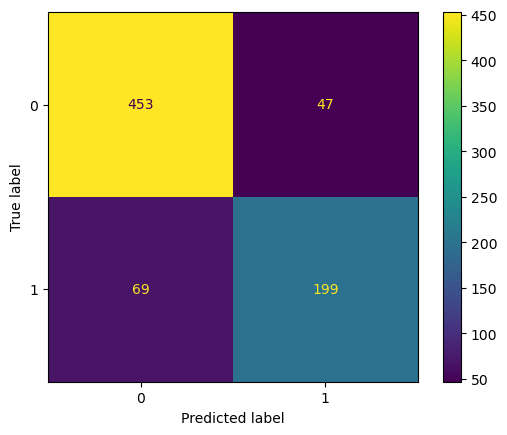

In [27]:
ypred = tree_pred(x,tr)
yact = y

confusion_matrix = metrics.confusion_matrix(yact, ypred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [6]:
# Bagging tree grow, i.e. tree grow with bootstrap aggregating
def tree_grow_b(x, y, nmin, minleaf, nfeat, m):
    n = x.shape[0]
    tree_bags = []
    for i in range(m):
        index = np.random.choice(n, size=n, replace=True)
        new_x = x[index]

        tree = tree_grow(new_x,y,nmin,minleaf,nfeat)
        tree_bags.append(tree)

    return tree_bags # should be a list of trees

In [7]:
# Tree prediction with bagging
def tree_pred_b(x, tree_bags):
    # for each store what the trees would predict
    predictions = []
    for tree in tree_bags:
        predictions.append(tree_pred(x, tree))

    #find the majority prediction
    Y = stats.mode(np.array(predictions).T, axis=1, keepdims=False)

    return Y.mode.flatten() # Should return a vector y where y[i] contains the predicted class label for row i of x


In [8]:
print(tree_pred_b(x_test, tree_grow_b(x, y, 10, 10, 4, 6)))

[0. 0. 0.]


part 2

In [9]:
def accuracy(actual, predicted):
    return np.sum(actual == predicted) / len(actual)

def precision(actual, predicted):
    TP = np.sum((actual == 1) & (predicted == 1))
    FP = np.sum((actual == 0) & (predicted == 1))

    if (TP + FP) > 0:
        return TP / (TP + FP)
    else:
        return 0

def recall(actual, predicted):
    TP = np.sum((actual == 1) & (predicted == 1))
    FN = np.sum((actual == 1) & (predicted == 0))
    
    if (TP + FN) > 0:
        return TP / (TP + FN)
    else:
        return 0

In [10]:
def counts(a):
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [11]:
#TRAINING DATA
file_path1 = 'eclipse-metrics-packages-2.0.csv'

eclipse2 = pd.read_csv(file_path1, sep=';')
features = ['pre','ACD_avg', 'ACD_max', 'ACD_sum', 'FOUT_avg', 'FOUT_max', 'FOUT_sum', 'MLOC_avg', 'MLOC_max', 'MLOC_sum', 'NBD_avg', 'NBD_max', 'NBD_sum', 'NOCU', 'NOF_avg', 'NOF_max', 'NOF_sum', 'NOI_avg', 'NOI_max', 'NOI_sum', 'NOM_avg', 'NOM_max', 'NOM_sum', 'NOT_avg', 'NOT_max', 'NOT_sum', 'NSF_avg', 'NSF_max', 'NSF_sum', 'NSM_avg', 'NSM_max', 'NSM_sum', 'PAR_avg', 'PAR_max', 'PAR_sum', 'TLOC_avg', 'TLOC_max', 'TLOC_sum', 'VG_avg', 'VG_max', 'VG_sum']

X_train = eclipse2[features].to_numpy()
Y_train = (eclipse2['post'] != 0).astype(int).to_numpy() #make it binary (so zero when zero, and 1 when nonzero)

#TEST DATA
file_path2 = 'eclipse-metrics-packages-3.0.csv'
eclipse3 = pd.read_csv(file_path2, sep=';')
X_test = eclipse3[features].to_numpy()
Y_test = (eclipse3['post'] != 0).astype(int).to_numpy()

In [12]:
#columns
print(len(eclipse2.to_numpy()))
print(len(eclipse3.to_numpy()))

#features
print(len(eclipse2.to_numpy()[0]))
print(len(eclipse3.to_numpy()[0]))

377
661
211
211


In [13]:
counts((eclipse2['post'] != 0).astype(int).to_numpy())

{0: 187, 1: 190}

In [14]:
counts((eclipse3['post'] != 0).astype(int).to_numpy())

{0: 348, 1: 313}

In [15]:
# 1
tr = tree_grow(X_train, Y_train, 15, 5, 41)

predictions = tree_pred(X_test,tr)

print(f"Accuracy: {accuracy(Y_test, predictions)}")
print(f"Precision: {precision(Y_test,predictions)}")
print(f"Recall: {recall(Y_test,predictions)}")

Accuracy: 0.7170953101361573
Precision: 0.7368421052631579
Recall: 0.6261980830670927


In [33]:
#root
print("root value, splitpoint")
print(counts(tr.value), tr.splitpoint)
print(features[tr.feature],'\n')

#left
print("left value, splitpoint")
print(counts(tr.left.value), tr.left.splitpoint)
print('left feature')
print(features[tr.left.feature])
print("left left value, left right value")
print(counts(tr.left.left.value), counts(tr.left.right.value),'\n')

#right
print("right value, splitpoint")
print(counts(tr.right.value), tr.right.splitpoint)
print('left feature')
print(features[tr.right.feature])
print("right left value, right right value")
print(counts(tr.right.left.value),counts(tr.right.right.value))

root value, splitpoint
{0.0: 500, 1.0: 268} 127.5
ACD_avg 

left value, splitpoint
{0.0: 391, 1.0: 94} 28.5
left feature
MLOC_avg
left left value, left right value
{0.0: 248, 1.0: 23} {0.0: 143, 1.0: 71} 

right value, splitpoint
{0.0: 109, 1.0: 174} 29.4
left feature
FOUT_max
right left value, right right value
{0.0: 46, 1.0: 21} {0.0: 63, 1.0: 153}


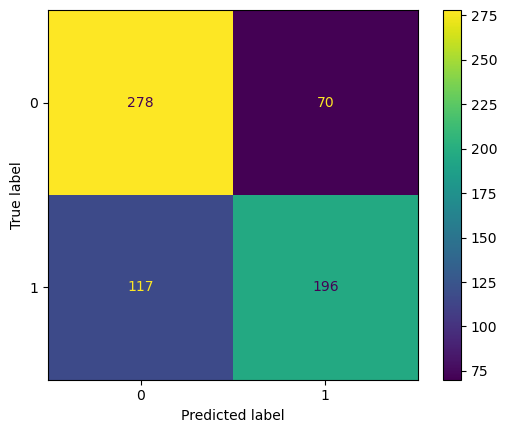

In [18]:
confusion_matrix1 = metrics.confusion_matrix(Y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [19]:
#2
tr_b = tree_grow_b(X_train, Y_train, 15, 5, 41, 100)
predictions_b = tree_pred_b(X_test,tr_b)

print(f"Accuracy: {accuracy(Y_test, predictions_b)}")
print(f"Precision: {precision(Y_test,predictions_b)}")
print(f"Recall: {recall(Y_test,predictions_b)}")

Accuracy: 0.48714069591527986
Precision: 0.45075757575757575
Recall: 0.3801916932907348


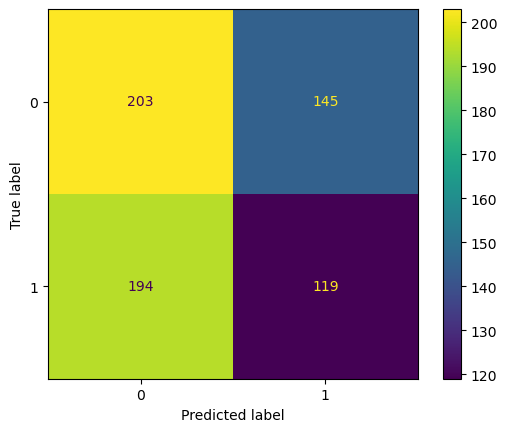

In [20]:
confusion_matrix2 = metrics.confusion_matrix(Y_test, predictions_b)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [21]:
#3
tr_rf = tree_grow_b(X_train, Y_train, 15, 5, 6, 100)

predictions_rf = tree_pred_b(X_test,tr_rf)

print(f"Accuracy: {accuracy(Y_test, predictions_rf)}")
print(f"Precision: {precision(Y_test,predictions_rf)}")
print(f"Recall: {recall(Y_test,predictions_rf)}")

Accuracy: 0.49319213313161875
Precision: 0.46099290780141844
Recall: 0.41533546325878595


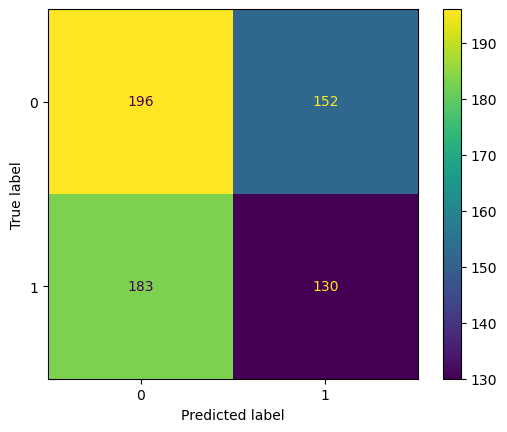

In [22]:
confusion_matrix3 = metrics.confusion_matrix(Y_test, predictions_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = [0, 1])

cm_display.plot()
plt.show()